## Classification on the ‘credit-g’ dataset

You can download the dataset with ‘fetch_openml(‘credit_g’)’ and see it’s description at
https://www.openml.org/d/31

### 1.1 
Determine which features are continuous and which are categorical.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

# to disregard warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset_31_credit-g.csv')

In [3]:
cont = df.columns[df.dtypes != object]
cate = df.columns[df.dtypes == object]
# print("Continuous features : ", cont )
# print("cat features : ", cate )
df.dtypes != object

checking_status           False
duration                   True
credit_history            False
purpose                   False
credit_amount              True
savings_status            False
employment                False
installment_commitment     True
personal_status           False
other_parties             False
residence_since            True
property_magnitude        False
age                        True
other_payment_plans       False
housing                   False
existing_credits           True
job                       False
num_dependents             True
own_telephone             False
foreign_worker            False
class                     False
dtype: bool

Note: last feature(column), which is class is a target.
The distinction between continuous and categorical features are calculated from looking at the data types. This reasoning coincides with the data website's description in that the data value with types of continuous are marked as "numeric" vs other values are marked as "nominal"


Continuous features : 
'duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', and 'num_dependents'

Categorical features : 'checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone', and
       'foreign_worker', 

### 1.2 
Visualize the univariate distribution of each continuous feature, and the distribution of the target.


In [4]:
list(cont)

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [5]:
cont

for i in cont:
    print(i)

duration
credit_amount
installment_commitment
residence_since
age
existing_credits
num_dependents


In [6]:
df['class'].value_counts()


good    700
bad     300
Name: class, dtype: int64

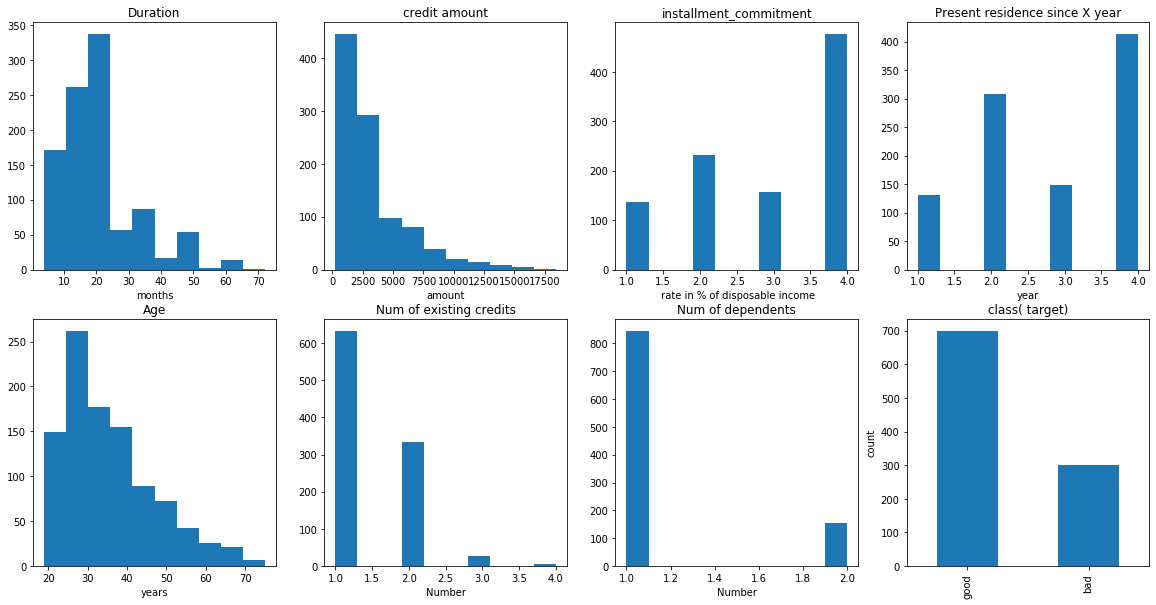

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))

ax[0,0].hist(df.duration)
ax[0,0].set_xlabel("months")
ax[0,0].set_title("Duration")

ax[0,1].hist(df.credit_amount)
ax[0,1].set_xlabel("amount")
ax[0,1].set_title("credit amount")

ax[0,2].hist(df.installment_commitment)
ax[0,2].set_xlabel(" rate in % of disposable income")
ax[0,2].set_title("installment_commitment")

ax[0,3].hist(df.residence_since)
ax[0,3].set_xlabel("year")
ax[0,3].set_title("Present residence since X year")

ax[1,0].hist(df.age)
ax[1,0].set_xlabel("years")
ax[1,0].set_title("Age")

ax[1,1].hist(df.existing_credits)
ax[1,1].set_xlabel("Number")
ax[1,1].set_title("Num of existing credits")

ax[1,2].hist(df.num_dependents)
ax[1,2].set_xlabel("Number")
ax[1,2].set_title("Num of dependents")

df['class'].value_counts().plot(kind='bar',ax = ax[1,3])
ax[1,3].set_ylabel("count")
ax[1,3].set_title("class( target)");

### 1.3 
Split data into training and test set. Do not use the test set until a final evaluation in 1.5.
Preprocess the data (such as treatment of categorical variables) without using a pipeline and
evaluate an initial LogisticRegression model with an training/validation split.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# One-Hot (Dummy) Encoding
X = pd.get_dummies(X)

# train, valid, test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state = 123)

logR = LogisticRegression()
logR.fit(X_train, y_train)
print("train-val score w/o  scaling:", logR.score(X_val,y_val))

# i.e. scaling, optional as noted on Piazza
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
logR = LogisticRegression()
logR.fit(X_train_scaled, y_train)

X_valid_scaled = scaler.transform(X_val)
print("train-val score with scaling:", logR.score(X_valid_scaled,y_val))

train-val score w/o  scaling: 0.75
train-val score with scaling: 0.7446808510638298


### 1.4 
Use ColumnTransformer and pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate
Logistic Regression, linear support vector machines and nearest neighbors using
cross-validation. How different are the results? How does scaling the continuous features with
StandardScaler influence the results?

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# train, test split  (no validation set used since it would only use cross_val_score)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In [10]:

#i.e. First, without scaling cont features
categorical = X_train.dtypes == object
preprocess = make_column_transformer((OneHotEncoder(), categorical))

#pipeline
pipe_logR = make_pipeline(preprocess, LogisticRegression(solver='lbfgs',dual=False))
pipe_svc = make_pipeline(preprocess, LinearSVC(dual=False))
pipe_knn = make_pipeline(preprocess, KNeighborsClassifier())

# average of cross validation
logR_score = np.mean(cross_val_score(pipe_logR, X_train, y_train, cv=10))
svc_score = np.mean(cross_val_score(pipe_svc, X_train, y_train, cv=10))
knn_score = np.mean(cross_val_score(pipe_knn, X_train, y_train, cv=10))

# preprocess with scale
preprocess_scale = make_column_transformer(
                (StandardScaler(), ~categorical), 
                (OneHotEncoder(), categorical))
pipe_logR = make_pipeline(preprocess_scale, LogisticRegression(solver='lbfgs', dual=False))
pipe_svc = make_pipeline(preprocess_scale, LinearSVC(dual=False))
pipe_knn = make_pipeline(preprocess_scale, KNeighborsClassifier())

logR_score_scale = np.mean(cross_val_score(pipe_logR, X_train, y_train, cv=10))
svc_score_scale = np.mean(cross_val_score(pipe_svc, X_train, y_train, cv=10))
knn_score_scale = np.mean(cross_val_score(pipe_knn, X_train, y_train, cv=10))

print("logistic Reg score without scale: ",logR_score, "\n"
      "linear SVM score without scale: ",svc_score, "\n"
      "nearest neighbor score without scale: ",knn_score)
print("")
print("logistic Reg score with scale: ",logR_score_scale, "\n"
      "linear SVM score with scale: ",svc_score_scale, "\n"
      "nearest neighbor score with scale: ",knn_score_scale)

logistic Reg score without scale:  0.7346666666666667 
linear SVM score without scale:  0.7413333333333333 
nearest neighbor score without scale:  0.6946666666666667

logistic Reg score with scale:  0.7466666666666667 
linear SVM score with scale:  0.7466666666666667 
nearest neighbor score with scale:  0.7346666666666667


Without scaling the continuous features, there are some differnences in scores among the logistic regression, linear SVM , and nearest neighbors in that nearest neighbor's score is clearly lower than the other two, and there is no big difference in score between logistic regression and nearest neighbor (logistic regression's score is slightly lower than linear SVM's score). Also for the logistic regression, oneHotEncoding resulsts in slightly lower score than the score value found in 1.3.

With the scaling the continuous features, the scores of each of the 3 models increase overall, at least slightly. Difference in scores among the 3 models decreased, particularly between score of nearest neighbor agains the other two models, and now the score between logistic regression and the linear SVM are really close (due to the random_state=123, diff random state still results in pretty close result).

### 1.5 
Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the be
model on the test set.
Visualize the performance as function of the parameters for all three models.

In [11]:
#pipe_svc.get_params()
#pipe_svc.get_params().keys()

In [12]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

param_grid_logR = {'logisticregression__C': np.logspace(-4, 6, 11)}
param_grid_svc = {'linearsvc__C': np.logspace(-4, 6, 11)}
param_grid_knn = {'kneighborsclassifier__n_neighbors': np.arange(1,30,2) }

In [13]:
grid_logR = GridSearchCV(pipe_logR, param_grid= param_grid_logR, cv=10)
grid_logR.fit(X_train, y_train)
gridS_CV_logR_test_score = grid_logR.score(X_test, y_test) # test score
gridS_CV_logR_bestP = grid_logR.best_params_ #save best param for log reg

grid_svm = GridSearchCV(pipe_svc, param_grid = param_grid_svc, cv=10)
grid_svm.fit(X_train, y_train)
gridS_CV_svm_test_score = grid_svm.score(X_test, y_test)
gridS_CV_svm_bestP = grid_svm.best_params_ # save best param for svm


grid_knn = GridSearchCV(pipe_knn, param_grid = param_grid_knn, cv=10)
grid_knn.fit(X_train, y_train)
gridS_CV_knn_test_score = grid_knn.score(X_test, y_test)


print("log Reg test-set score: {:.3f}".format(gridS_CV_logR_test_score))
print("linear svc test-set score: {:.3f}".format(gridS_CV_svm_test_score))
print("Nearest neighbor test-set score: {:.3f}".format(gridS_CV_knn_test_score))


log Reg test-set score: 0.732
linear svc test-set score: 0.724
Nearest neighbor test-set score: 0.716


Score of  nearest neighbor models are slightly higher than the scores of the "unscaled" model. However, compared to the scores of the scaled models, all of the 3 models have lower socres.

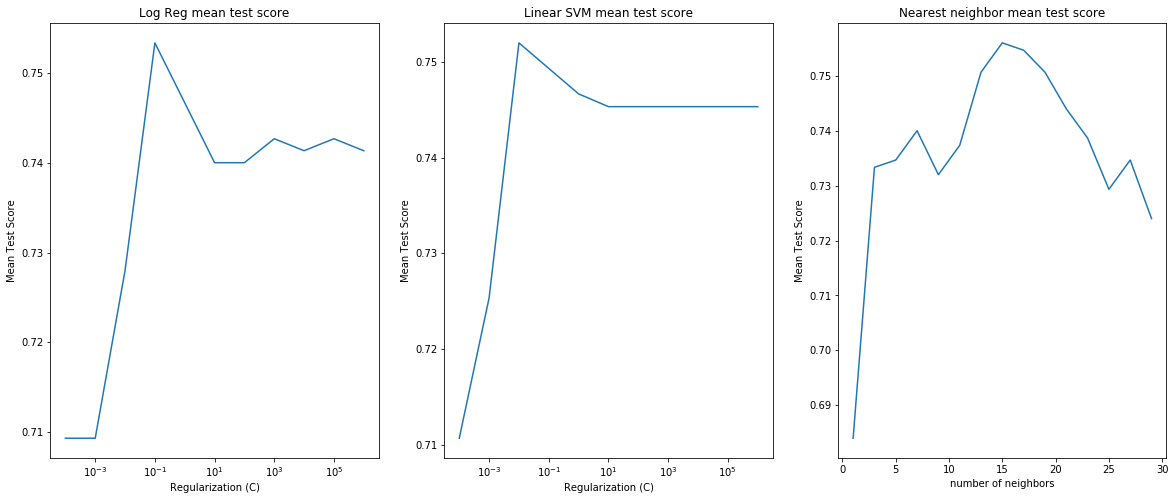

In [14]:
fig, ax = plt.subplots(1,3, figsize=(20, 8))
ax[0].plot( np.logspace(-4, 6, 11), grid_logR.cv_results_['mean_test_score'])
ax[0].set_xlabel("Regularization (C)")
ax[0].set_ylabel("Mean Test Score")
ax[0].set_title("Log Reg mean test score")
ax[0].set_xscale('log')

ax[1].plot(np.logspace(-4, 6, 11), grid_svm.cv_results_['mean_test_score'])
ax[1].set_xlabel("Regularization (C)")
ax[1].set_ylabel("Mean Test Score")
ax[1].set_title("Linear SVM mean test score")
ax[1].set_xscale('log')

ax[2].plot(np.arange(1,30,2), grid_knn.cv_results_['mean_test_score'])
ax[2].set_xlabel("number of neighbors")
ax[2].set_ylabel("Mean Test Score")
ax[2].set_title("Nearest neighbor mean test score");

### 1.6 
Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the
parameters that are found change? Do they change if you change the random seed of the
shuffling? Or if you change the random state of the split into training and test data?

In [15]:
from sklearn.model_selection import cross_val_score, KFold

In [16]:
# note: stratified k fold is default for classifcation

kf = KFold(n_splits=5, shuffle=True)
kf_rand  = KFold(n_splits=5, shuffle=True, random_state = 123)
kf_rand_0 = KFold(n_splits=5, shuffle=True, random_state = 0)

#===============logistic regression===================

# previous random state = 123 in test split

grid_logR_kf = GridSearchCV(pipe_logR, param_grid_logR, cv=kf)
grid_logR_kf.fit(X_train, y_train)

# in KFold, changed random_state in shuffling from 123 to 0
grid_logR_kf_shuf_0 = GridSearchCV(pipe_logR,param_grid_logR, cv=kf_rand_0)
grid_logR_kf_shuf_0.fit(X_train, y_train)

# With changed random_state in test split from 123 to 0
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)
grid_logR_kf_split0 = GridSearchCV(pipe_logR, param_grid_logR, cv=kf)
grid_logR_kf_split0 .fit(X_train, y_train)

# print("log Reg mean CV score: {:.3f}".format(grid_logR.best_score_))
print("Logistic regression ")
print("skf : {}".format(grid_logR.best_params_))
print("kf  : {}".format(grid_logR_kf.best_params_))
print("kf, changed r_seed 123->0 in shuffling : {}".format(grid_logR_kf_shuf_0.best_params_))
print("kf, changed r_seed 123->0 in train/test:{}".format(grid_logR_kf_split0.best_params_))
print("")


#==============For Linear SVM===============

# previous random state = 123 in test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)
grid_svm_kf = GridSearchCV(pipe_svc, param_grid_svc, cv=kf)
grid_svm_kf.fit(X_train, y_train)

# in KFold, changed random_state in shuffling from 123 to 0
grid_svm_kf_shuf0 = GridSearchCV(pipe_svc,param_grid_svc, cv=kf_rand_0)
grid_svm_kf_shuf0.fit(X_train, y_train)

# With changed random_state in test split from 123 to 0
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)
grid_svm_kf_split0 = GridSearchCV( pipe_svc,param_grid_svc, cv=kf)
grid_svm_kf_split0.fit(X_train, y_train)

print("Linear SVM, best parameter ")
print("skf : {}".format(grid_svm.best_params_))
print("kf : {}".format(grid_svm_kf.best_params_))
print("kf, changed r_seed 123->0 in shuffling : {}".format(grid_svm_kf_shuf0.best_params_))
print("kf, changed r_seed 123->0 in train/test:{}".format(grid_svm_kf_split0.best_params_))
print("")


#==============For KNN ====================

# previous random state = 123 in test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)
grid_knn_kf = GridSearchCV(pipe_knn,param_grid_knn, cv=kf)
grid_knn_kf.fit(X_train, y_train)

# in KFold, changed random_state in shuffling from 123 to 0
grid_knn_kf_shuf0 = GridSearchCV(pipe_knn,param_grid_knn, cv=kf_rand_0)
grid_knn_kf_shuf0.fit(X_train, y_train)

# With changed random_state in test split from 123 to 0
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)
grid_knn_kf_split0 = GridSearchCV( pipe_knn,param_grid_knn, cv=kf)
grid_knn_kf_split0.fit(X_train, y_train)

print("KNN, best param")
print("skf : {}".format(grid_knn.best_params_))
print("kf  : {}".format(grid_knn_kf.best_params_))
print("kf, changed r_seed 123->0 in shuffling : {}".format(grid_knn_kf_shuf0.best_params_))
print("kf, changed r_seed 123->0 in train/test:{}".format(grid_knn_kf_split0.best_params_))
print("")

Logistic regression 
skf : {'logisticregression__C': 0.1}
kf  : {'logisticregression__C': 0.1}
kf, changed r_seed 123->0 in shuffling : {'logisticregression__C': 0.1}
kf, changed r_seed 123->0 in train/test:{'logisticregression__C': 0.1}

Linear SVM, best parameter 
skf : {'linearsvc__C': 0.01}
kf : {'linearsvc__C': 0.01}
kf, changed r_seed 123->0 in shuffling : {'linearsvc__C': 0.1}
kf, changed r_seed 123->0 in train/test:{'linearsvc__C': 0.1}

KNN, best param
skf : {'kneighborsclassifier__n_neighbors': 15}
kf  : {'kneighborsclassifier__n_neighbors': 17}
kf, changed r_seed 123->0 in shuffling : {'kneighborsclassifier__n_neighbors': 15}
kf, changed r_seed 123->0 in train/test:{'kneighborsclassifier__n_neighbors': 7}



### 1.7
Visualize the 20 most important coefficients for LogisticRegression and Linear Support
Vector Machines using hyper-parameters that performed well in the grid-search.

In [17]:
# train, test split  (no validation set used since it would only use cross_val_score)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

print("logistic regrression best param", gridS_CV_logR_bestP)
print("linear SVM best param", gridS_CV_svm_bestP )

logistic regrression best param {'logisticregression__C': 0.1}
linear SVM best param {'linearsvc__C': 0.01}


In [18]:
logR_pipe_best = make_pipeline(preprocess_scale, LogisticRegression(C = 0.1)) #pipeline using best parameter
logR_pipe_best.fit(X_train, y_train)
coeff_logR = logR_pipe_best['logisticregression'].coef_

SVM_pipe_best = make_pipeline(preprocess_scale, LinearSVC(C = 0.01))
SVM_pipe_best.fit(X_train, y_train)
coeff_svm = SVM_pipe_best['linearsvc'].coef_

#one hot encoder (OHC)
OHC_logR = logR_pipe_best.named_steps['columntransformer']._transformers[1][1]
#OHC_logR.fit(X_train, y_train).get_feature_names().tolist()